In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import pdb
from sklearn.linear_model import LogisticRegression
import time



# For producing decision tree diagrams.
from IPython.core.display import Image, display
from sklearn.externals.six import StringIO

import seaborn as sns
sns.set(style="ticks")

from sklearn.externals import joblib




ImportError: No module named 'seaborn'

Raw training set shape: (15120, 56)
['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40']
After split, Train and Dev dataset shapes are: (11340, 56) (3780,

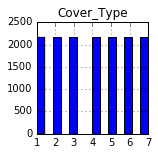

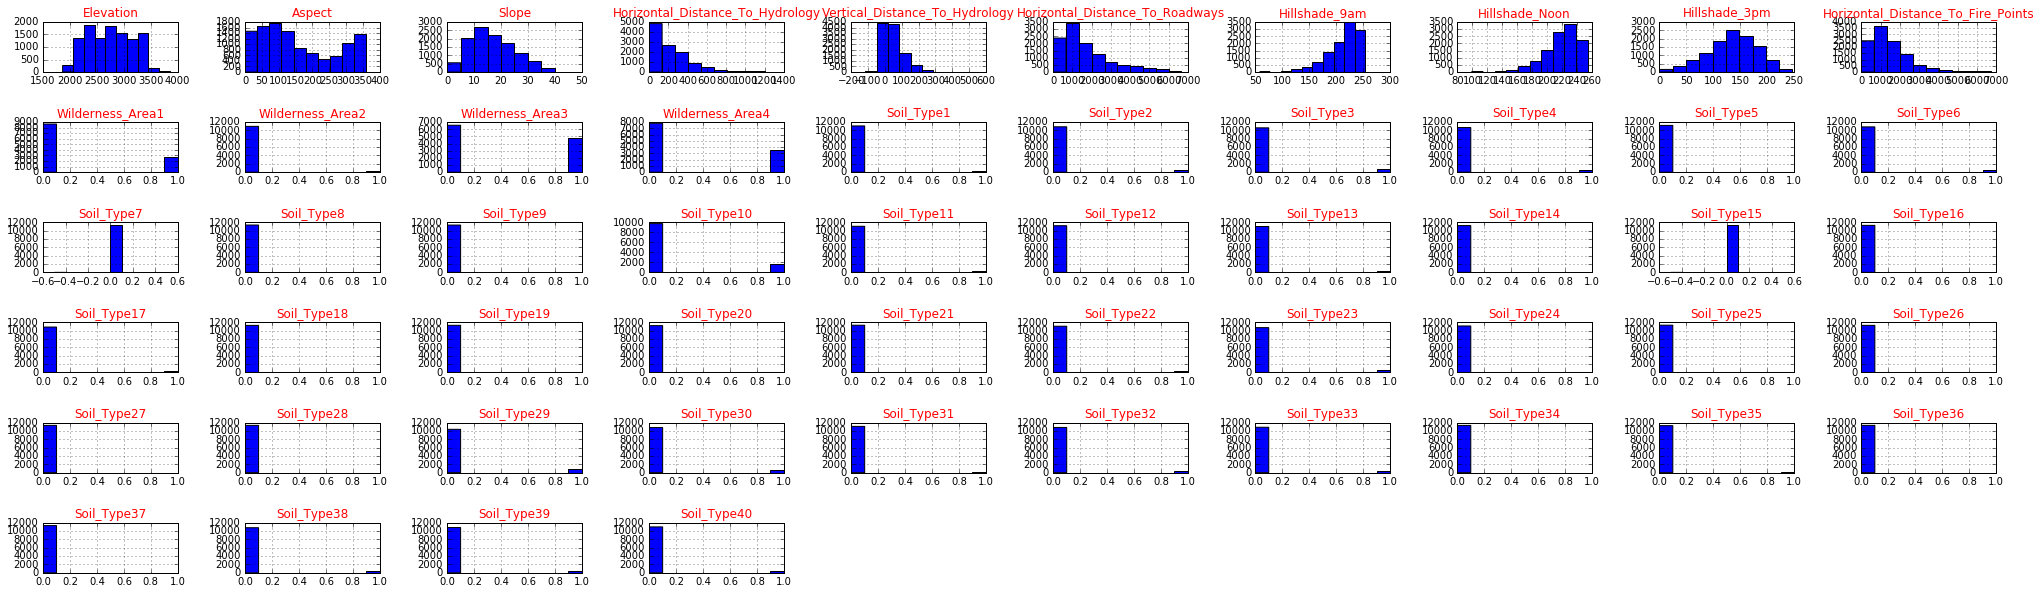

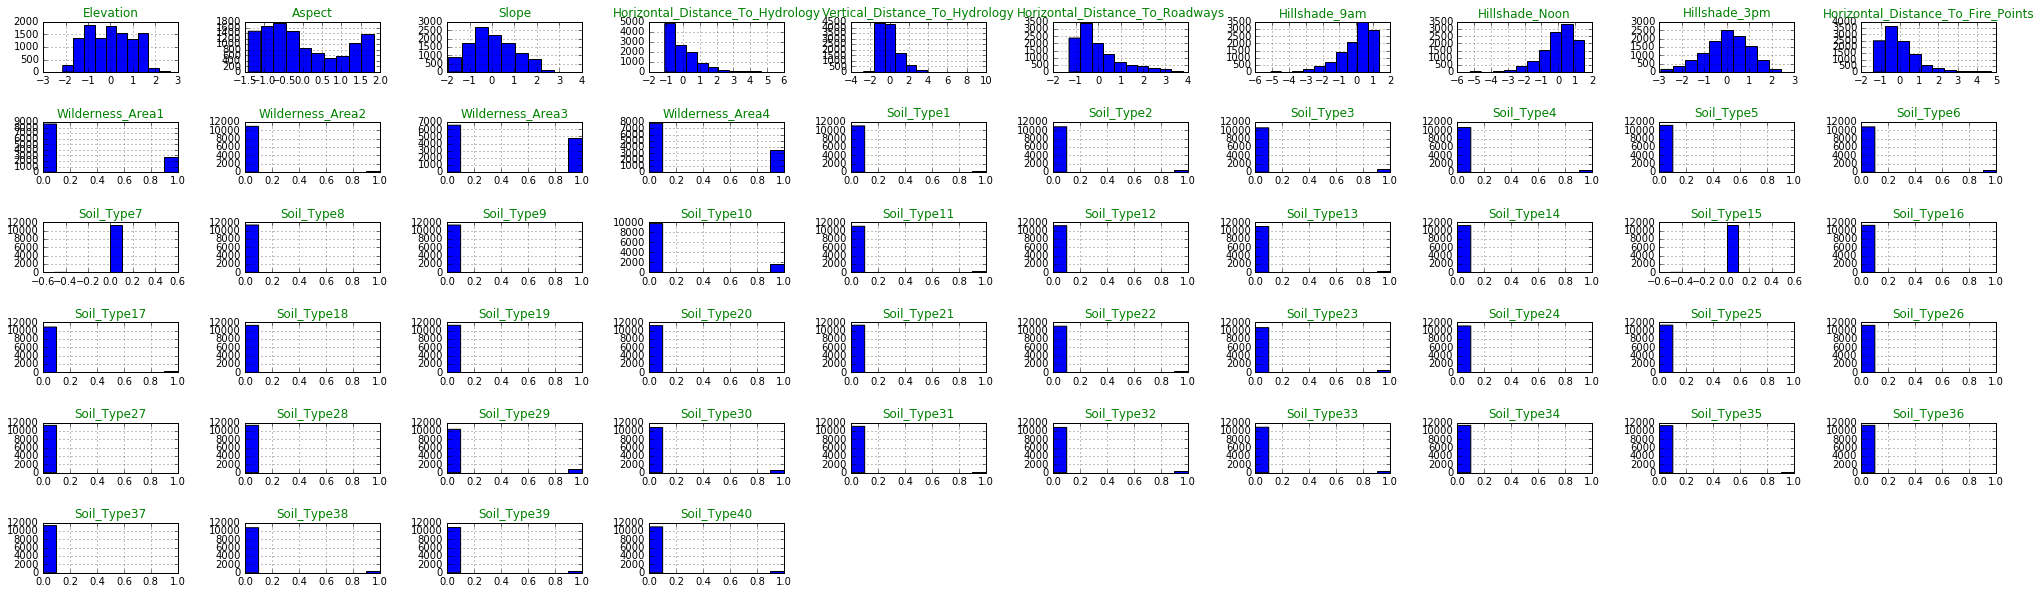

In [2]:
train_df = pd.read_csv('train.csv')

# check for missing values in frame. 
train_df.isnull().values.any()
print("Raw training set shape:",train_df.shape)

predictors = list(train_df) # includes ID and target/class columns
train_id = predictors.pop(0) # pop out ID column
target = list.pop(predictors) # pop out target column
print(predictors)

# Standardizing ...

# two kinds of normalization - min-max or z-score. z-score may lead to negative values for otherwise non-negative quantities 
# (such as altitude) - which may be ok from a prediction standpoint 

# should we be splitting after normalization. Or before? Before makes sense cause dev data should be a surrogate for actual - 
# - kaggle test data we have not seen yet. 
plt.figure(figsize=(2, 2))
ax = train_df['Cover_Type'].hist(bins=14) # Check to see if any stratification is required for train,dev split. 
ax.set_title('Cover_Type')
train_df, dev_df = train_test_split(train_df)

# display histograms for basic EDA. titles in Red. 
plt.figure(figsize=(35, 35))
plt.subplots_adjust(hspace=1.0,wspace=0.5)
for i in range(0,len(predictors)):
    plt.subplot(20,10,i+1)
    data = train_df[predictors[i]].T # transposing to view counts on y-axis
    ax = data.hist()
    ax.set_title(predictors[i],color='Red') 

# Need to store these values for normalizing new data presented to the eventual model for prediction. 
train_df_mean =  train_df.mean().astype(float)
train_df_sd = train_df.std().astype(float)
train_df_min = train_df.min().astype(float)
train_df_max = train_df.max().astype(float)

# going with z-scores. some columns may look weird. caveat emptor. note that dev-data is normalized based on train dist. 
train_df[predictors[0:10]] = (train_df[predictors[0:10]]-train_df_mean[predictors[0:10]])/train_df_sd[predictors[0:10]]
dev_df[predictors[0:10]] = (dev_df[predictors[0:10]]-train_df_mean[predictors[0:10]])/train_df_sd[predictors[0:10]]

print("After split, Train and Dev dataset shapes are:",train_df.shape, dev_df.shape)

# display histograms post normalization. Titles in Green.
plt.figure(figsize=(35, 35))
plt.subplots_adjust(hspace=1.0,wspace=0.5)
for i in range(0,len(predictors)):
    plt.subplot(20,10,i+1)
    data = train_df[predictors[i]].T # transposing to view counts on y-axis
    aax = data.hist()
    aax.set_title(predictors[i],color='Green') 




In [11]:
# Next, evaluate a Random Forest with 500 trees. 
rf = RandomForestClassifier(n_estimators=500, oob_score=True, criterion="entropy")
scores = cross_val_score(rf, train_df[predictors], train_df[target], cv=10)
print ("Mean R^2 = {:.3}".format(scores.mean()))

Mean R^2 = 0.857


In [20]:
rf.fit(train_df[predictors], train_df[target])
print(rf.score(dev_df[predictors], dev_df[target]))
dev_pred = rf.predict(dev_df[predictors])
print(classification_report(dev_df[target],dev_pred))

0.866666666667
             precision    recall  f1-score   support

          1       0.80      0.76      0.78       544
          2       0.80      0.72      0.76       514
          3       0.86      0.81      0.84       549
          4       0.91      0.98      0.94       534
          5       0.92      0.95      0.93       568
          6       0.84      0.87      0.85       528
          7       0.92      0.96      0.94       543

avg / total       0.86      0.87      0.86      3780



In [55]:
param_grid = [
    {'n_estimators': [100, 250, 500, 750, 1000, 1500], 'max_features': [2, 4, 6, 8, 'auto']},
    {'bootstrap': [False], 'n_estimators': [250, 500], 'max_features': [2, 4, 6, 8, 'auto']},
  ]
rf = RandomForestClassifier()

start_time = time.time()
grid_search = GridSearchCV(rf, param_grid, cv=5)
grid_search.fit(train_df[predictors], train_df[target])
end_time = time.time()
print("Wallclock time in secs for Random Forest Grid Search:",end_time - start_time)


Wallclock time in secs for Random Forest Grid Search: 2603.2594163417816


In [57]:
grid_search.best_params_

{'bootstrap': False, 'max_features': 8, 'n_estimators': 250}

In [7]:
# rf = RandomForestClassifier(**grid_search.best_params_)
rf = RandomForestClassifier(bootstrap=False, max_features=8, n_estimators=250)
rf.fit(train_df[predictors],train_df[target])
print(rf.score(dev_df[predictors], dev_df[target]))
dev_pred = rf.predict(dev_df[predictors])
print(classification_report(dev_df[target],dev_pred))

0.863227513228
             precision    recall  f1-score   support

          1       0.76      0.80      0.78       528
          2       0.81      0.68      0.74       567
          3       0.85      0.80      0.82       552
          4       0.93      0.96      0.95       538
          5       0.90      0.96      0.93       521
          6       0.83      0.89      0.85       524
          7       0.96      0.97      0.96       550

avg / total       0.86      0.86      0.86      3780



In [6]:
param_grid = {'n_estimators': [100,250,500,750],'max_features': [2, 4, 6, 8, 'log2'] }
rf = RandomForestClassifier(oob_score=True)


start_time = time.time()
random_search = RandomizedSearchCV(rf,param_distributions=param_grid, n_iter=20)
random_search.fit(train_df[predictors],train_df[target])
end_time = time.time()
print("Wallclock time in secs for Random Forest Grid Search:",end_time - start_time)


Wallclock time in secs for Random Forest Grid Search: 366.8167848587036


In [8]:
random_search.best_params_

{'max_features': 8, 'n_estimators': 750}

In [9]:
# random_rf = RandomForestClassifier(**random_search.best_params_)
random_rf = RandomForestClassifier(max_features=8, n_estimators=750)
random_rf.fit(train_df[predictors],train_df[target])
print(random_rf.score(dev_df[predictors], dev_df[target]))
dev_pred = random_rf.predict(dev_df[predictors])
print(classification_report(dev_df[target],dev_pred))

0.859523809524
             precision    recall  f1-score   support

          1       0.75      0.77      0.76       528
          2       0.81      0.67      0.73       567
          3       0.85      0.80      0.82       552
          4       0.92      0.96      0.94       538
          5       0.89      0.97      0.93       521
          6       0.83      0.89      0.85       524
          7       0.95      0.97      0.96       550

avg / total       0.86      0.86      0.86      3780



In [14]:
lsvc = LinearSVC(C=1)
lsvc.fit(train_df[predictors],train_df[target])
dev_pred = lsvc.predict(dev_df[predictors])
print(classification_report(dev_df[target],dev_pred))

             precision    recall  f1-score   support

          1       0.60      0.67      0.63       528
          2       0.60      0.42      0.49       567
          3       0.60      0.51      0.55       552
          4       0.79      0.89      0.84       538
          5       0.61      0.75      0.67       521
          6       0.58      0.59      0.58       524
          7       0.90      0.87      0.89       550

avg / total       0.67      0.67      0.67      3780



In [11]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1, algorithm='ball_tree', leaf_size=30)
knn.fit(train_df[predictors], train_df[target])
dev_pred = knn.predict(dev_df[predictors])
print(classification_report(dev_df[target],dev_pred))

             precision    recall  f1-score   support

          1       0.74      0.69      0.71       528
          2       0.73      0.64      0.68       567
          3       0.78      0.69      0.73       552
          4       0.89      0.94      0.91       538
          5       0.82      0.94      0.88       521
          6       0.75      0.81      0.78       524
          7       0.94      0.97      0.95       550

avg / total       0.81      0.81      0.81      3780



In [16]:
softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs",C=4)
softmax_reg.fit(train_df[predictors], train_df[target])
dev_pred = softmax_reg.predict(dev_df[predictors])
print(classification_report(dev_df[target],dev_pred))

             precision    recall  f1-score   support

          1       0.64      0.67      0.65       528
          2       0.62      0.51      0.56       567
          3       0.65      0.53      0.58       552
          4       0.81      0.87      0.84       538
          5       0.72      0.83      0.77       521
          6       0.61      0.67      0.64       524
          7       0.90      0.91      0.91       550

avg / total       0.71      0.71      0.71      3780



In [19]:
voter = VotingClassifier(
    estimators=[('rf', rf),('lr', softmax_reg),('rrf', random_rf), ('knn', knn)],
    voting='hard')
voter.fit(train_df[predictors], train_df[target])
dev_pred = voter.predict(dev_df[predictors])
print(classification_report(dev_df[target],dev_pred))


             precision    recall  f1-score   support

          1       0.75      0.78      0.77       528
          2       0.81      0.68      0.74       567
          3       0.86      0.80      0.83       552
          4       0.93      0.97      0.95       538
          5       0.90      0.96      0.93       521
          6       0.83      0.89      0.86       524
          7       0.95      0.97      0.96       550

avg / total       0.86      0.86      0.86      3780

